In [2]:
import tensorflow
from tensorflow import keras

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os, cv2, random
import numpy as np
import pandas as pd

In [5]:
from matplotlib import ticker
import seaborn as sns

In [6]:
TRAIN_DIR = './dogscats/train/'
TEST_DIR = './dogscats/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

In [7]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]

In [8]:
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [9]:
train_images = train_dogs[:1000] + train_cats[:1000]

In [10]:
random.shuffle(train_images)

In [11]:
test_images =  test_images[:25]

In [12]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [13]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T #transpose 
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [14]:
train = prep_data(train_images)
test = prep_data(test_images)

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 25


In [15]:
labels = []
for i in train_images:
    if 'dog.' in i:
        labels.append(1)
    else:
        labels.append(0)

In [16]:
labels[:10]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1]

In [17]:
train_images[:10]

['./dogscats/train/cat.10481.jpg',
 './dogscats/train/cat.10757.jpg',
 './dogscats/train/cat.10372.jpg',
 './dogscats/train/cat.10430.jpg',
 './dogscats/train/cat.10101.jpg',
 './dogscats/train/dog.1048.jpg',
 './dogscats/train/cat.10844.jpg',
 './dogscats/train/cat.10242.jpg',
 './dogscats/train/dog.10238.jpg',
 './dogscats/train/dog.1083.jpg']

Text(0.5, 1.0, 'Cats and Dogs')

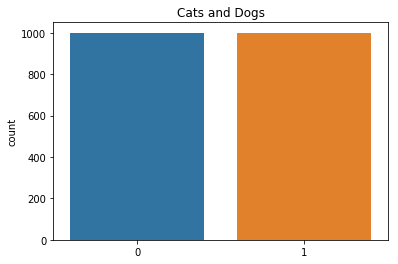

In [18]:
sns.countplot(labels)
plt.title('Cats and Dogs')

In [19]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5)) #inch
    plt.imshow(pair)
    plt.show()

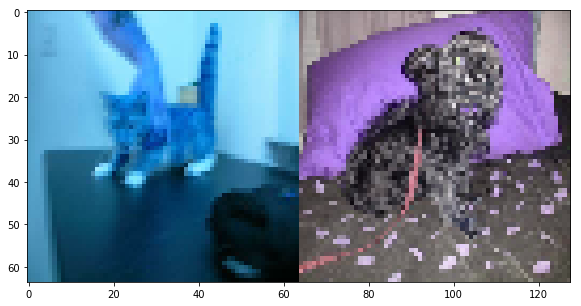

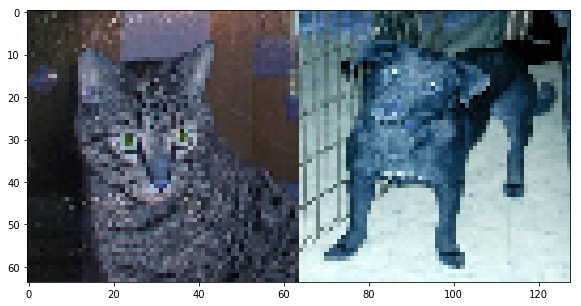

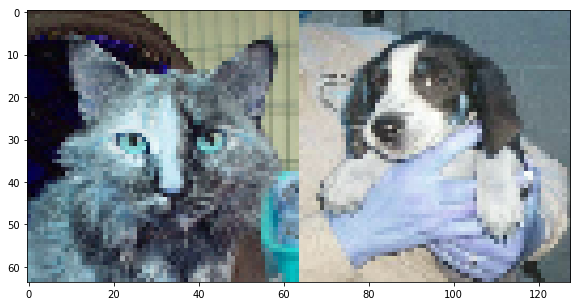

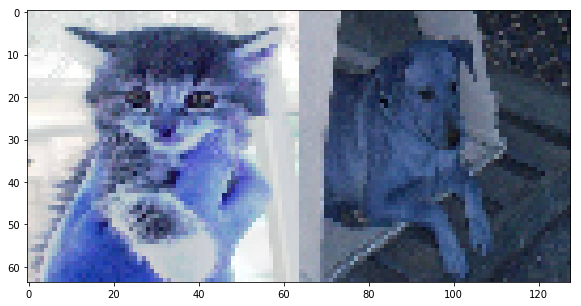

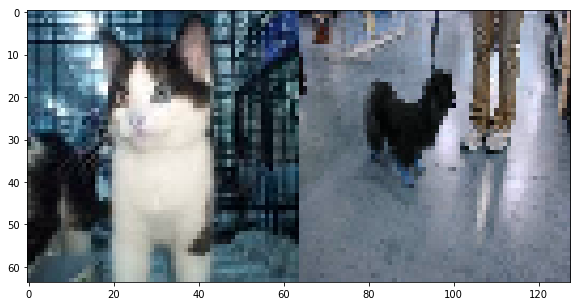

In [20]:
for idx in range(0,5):
    show_cats_and_dogs(idx)

Text(0.5, 1.0, 'Your Average Dog')

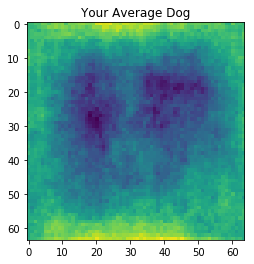

In [21]:
#平均を生成する
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg)
plt.title('Your Average Dog')

Text(0.5, 1.0, 'Your Average Cat')

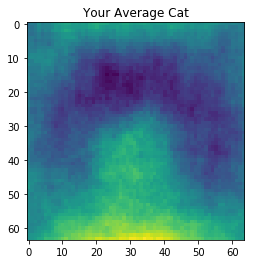

In [22]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg)
plt.title('Your Average Cat')

In [23]:
#modelの定義
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


In [24]:
optimizer = RMSprop(lr=1e-4)
#勾配降下法　lr = 学習率
objective = 'binary_crossentropy'

def catdog():
    model = Sequential()
    
    model.add(Convolution2D(32, (3, 3), padding='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first",pool_size=(2, 2)))
    
    model.add(Convolution2D(64,(3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first",pool_size=(2, 2)))
    
    model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first",pool_size=(2, 2)))
    
    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
#  model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first",pool_size=(2, 2)))
    

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

#data_format="channels_first" データの並び方をTFように変換

model = catdog()
    

In [25]:
#トレーニング
nb_epoch = 10
batch_size = 16

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto') 
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history


predictions, history = run_catdog()


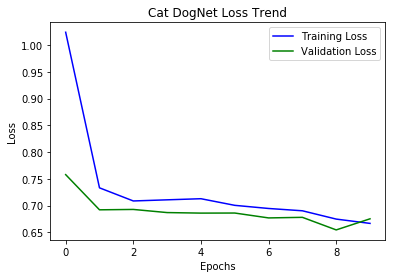

In [26]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cat DogNet Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

I am 51.00% sure this is a Dog


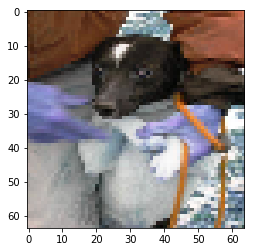

I am 51.12% sure this is a Cat


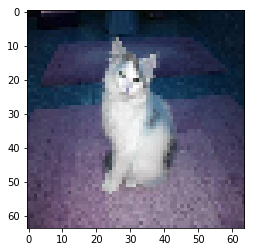

I am 60.81% sure this is a Cat


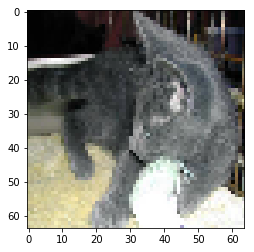

I am 57.14% sure this is a Dog


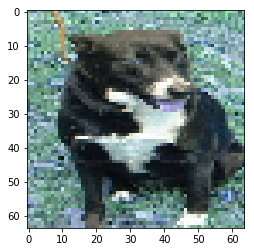

I am 63.68% sure this is a Dog


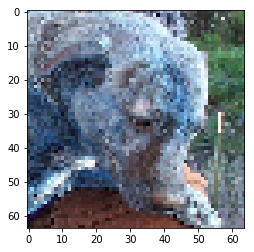

I am 54.30% sure this is a Cat


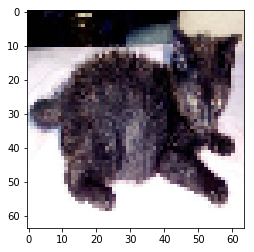

I am 59.48% sure this is a Dog


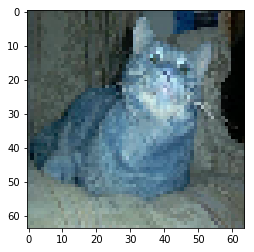

I am 54.50% sure this is a Dog


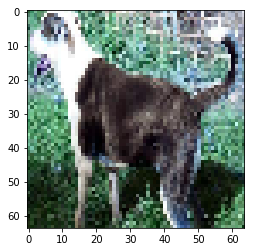

I am 56.64% sure this is a Dog


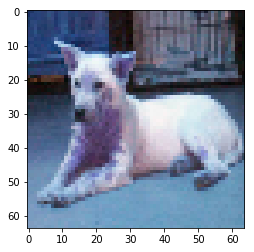

I am 51.36% sure this is a Dog


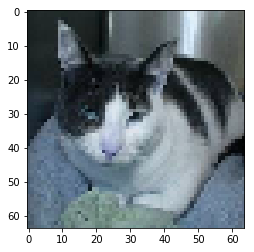

In [27]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()